# Codigo para la implementación de regresión spline en Python


In [7]:
pip install scikit-learn

  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.



k óptimo encontrado: 24
MSE mínimo: 0.047580
Número óptimo de funciones base: 24


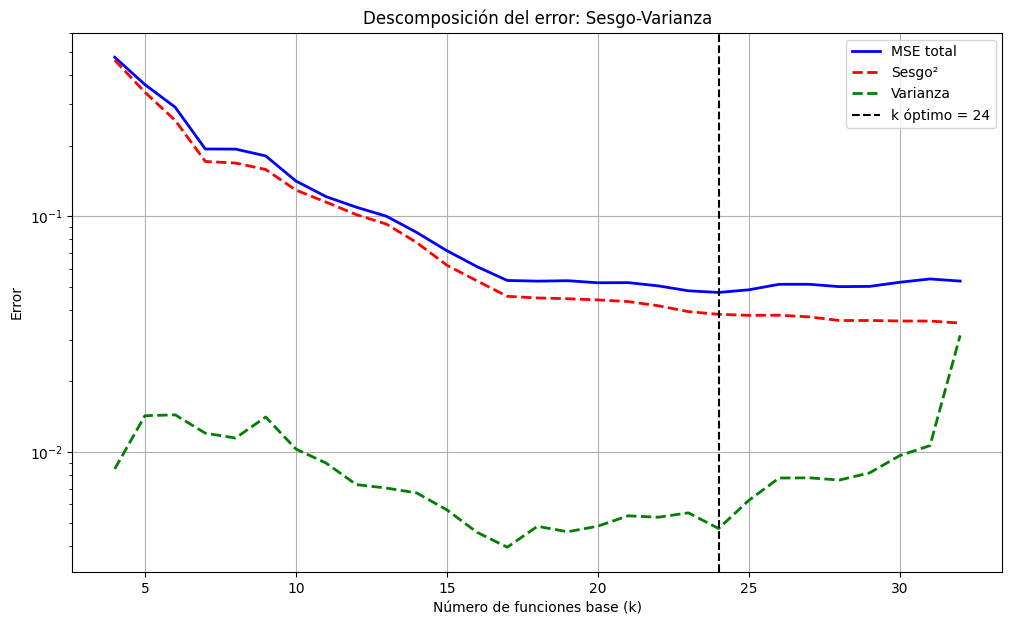


Para k óptimo = 24:
MSE total: 0.047580
Sesgo²: 0.038426
Varianza: 0.004738


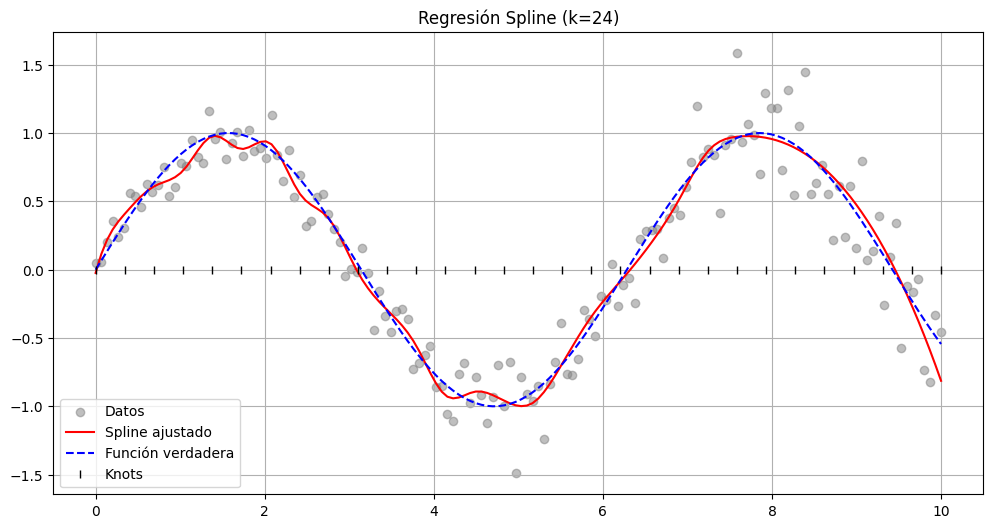

In [39]:
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

class SplineRegression:
    def __init__(self, knots, order=4):
        """
        Inicializa la regresión spline.
        
        Parámetros:
        knots (array): Ubicación de los knots
        order (int): Orden de los B-splines (4 para cúbicos)
        """
        self.knots = np.sort(np.array(knots))  # Aseguramos que los knots estén ordenados
        self.order = order
        self.max_basis = len(knots) + order - 2
            
        # Crear el vector de knots extendido
        self.extended_knots = self._create_extended_knots()
        
    def _create_extended_knots(self):
        """Crea el vector de knots extendido añadiendo knots en los extremos."""
        left_knots = np.repeat(self.knots[0], self.order)
        right_knots = np.repeat(self.knots[-1], self.order)
        return np.concatenate([left_knots, self.knots, right_knots])
    
    def _evaluate_basis(self, x, n_basis):
        """Evalúa todas las funciones base B-spline en los puntos x."""
        basis_matrix = np.zeros((len(x), n_basis))
        
        for i in range(n_basis):
            # Crear el i-ésimo B-spline
            t = self.extended_knots[i:i+self.order+1]
            spl = BSpline.basis_element(t, self.order-1)
            # Evaluar el B-spline en x
            basis_matrix[:, i] = spl(x)
            
        return basis_matrix
    
    def _weighted_least_squares(self, X, y, weights=None):
        """
        Realiza el ajuste por mínimos cuadrados ponderados usando SVD.
        
        Parámetros:
        X (array): Matriz de diseño
        y (array): Variable dependiente
        weights (array): Pesos para cada observación
        
        Retorna:
        array: Coeficientes estimados
        """
        if weights is None:
            weights = np.ones(len(y))
        
        # Aplicar pesos a X e y
        sqrt_weights = np.sqrt(weights)
        X_weighted = X * sqrt_weights[:, np.newaxis]
        y_weighted = y * sqrt_weights
        
        # Resolver usando mínimos cuadrados con SVD
        coefficients, residuals, rank, s = np.linalg.lstsq(X_weighted, y_weighted, rcond=None)
        
        return coefficients
    
    def find_optimal_k(self, X, y, k_range=None, n_folds=5):
        """
        Encuentra el número óptimo de funciones base minimizando el MSE.
        """
        X = np.array(X)
        y = np.array(y)
        
        if k_range is None:
            k_range = range(self.order, min(self.max_basis + 1, len(X)))
            
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        mse_scores = {}
        bias_scores = {}
        variance_scores = {}
        
        for k in k_range:
            # Calcular MSE por validación cruzada
            fold_scores = []
            for train_idx, val_idx in kf.split(X):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                try:
                    basis_train = self._evaluate_basis(X_train, k)
                    coefficients = self._weighted_least_squares(basis_train, y_train)
                    basis_val = self._evaluate_basis(X_val, k)
                    y_pred = basis_val @ coefficients
                    mse = mean_squared_error(y_val, y_pred)
                    fold_scores.append(mse)
                except np.linalg.LinAlgError:
                    fold_scores.append(np.inf)
            
            mse_scores[k] = np.mean(fold_scores)
            
            # Calcular sesgo y varianza
            try:
                bias_squared, variance = self._calculate_bias_variance(X, y, k)
                bias_scores[k] = bias_squared
                variance_scores[k] = variance
            except np.linalg.LinAlgError:
                bias_scores[k] = np.inf
                variance_scores[k] = np.inf
        
        # Encontrar k que minimiza el MSE
        valid_k = {k: mse for k, mse in mse_scores.items() if np.isfinite(mse)}
        if not valid_k:
            raise ValueError("No se encontró un k válido. Intenta con diferentes knots o rangos de k.")
        
        optimal_k = min(valid_k, key=valid_k.get)
        print(f"\nk óptimo encontrado: {optimal_k}")
        print(f"MSE mínimo: {mse_scores[optimal_k]:.6f}")
        
        # Calcular punto de intersección para mantener la información
        k_values = sorted(k_range)
        bias_values = [bias_scores[k] for k in k_values]
        variance_values = [variance_scores[k] for k in k_values]
        
        # Buscar intersección
        intersection_k = None
        intersection_value = None
        
        for i in range(len(k_values) - 1):
            bias_diff = bias_values[i] - variance_values[i]
            next_bias_diff = bias_values[i+1] - variance_values[i+1]
            
            if (bias_diff >= 0 and next_bias_diff <= 0) or (bias_diff <= 0 and next_bias_diff >= 0):
                k1, k2 = k_values[i], k_values[i+1]
                b1, b2 = bias_values[i], bias_values[i+1]
                v1, v2 = variance_values[i], variance_values[i+1]
                
                if b1 != v1:
                    t = (v1 - b1) / ((b2 - b1) - (v2 - v1))
                    intersection_k = k1 + t * (k2 - k1)
                    intersection_value = b1 + t * (b2 - b1)
                else:
                    intersection_k = k1
                    intersection_value = b1
        
        # Guardar todos los valores calculados
        self.optimal_k = optimal_k
        self.mse_scores = mse_scores
        self.bias_scores = bias_scores
        self.variance_scores = variance_scores
        self.intersection_k = intersection_k
        self.intersection_value = intersection_value
        
        return self.optimal_k
        
    def fit(self, X, y, weights=None, k=None):
        """
        Ajusta la regresión spline a los datos.
        """
        X = np.array(X)
        y = np.array(y)
        
        if k is None:
            if not hasattr(self, 'optimal_k'):
                self.optimal_k = self.find_optimal_k(X, y)
            k = self.optimal_k
            
        self.n_basis = k
        basis_matrix = self._evaluate_basis(X, k)
        self.coefficients = self._weighted_least_squares(basis_matrix, y, weights)
        
        return self
    
    def predict(self, X):
        """
        Realiza predicciones para nuevos datos X.
        """
        X = np.array(X)
        basis_matrix = self._evaluate_basis(X, self.n_basis)
        return basis_matrix @ self.coefficients
    
        
    def _calculate_bias_variance(self, X, y, k, n_bootstrap=100):
        """
        Calcula el sesgo y la varianza usando bootstrap.
        
        Parámetros:
        X: array de entrada
        y: valores objetivo
        k: número de funciones base
        n_bootstrap: número de muestras bootstrap
        
        Retorna:
        bias², variance
        """
        n_samples = len(X)
        predictions = np.zeros((n_samples, n_bootstrap))
        
        for i in range(n_bootstrap):
            # Generar muestra bootstrap
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_boot, y_boot = X[indices], y[indices]
            
            # Ajustar modelo y predecir
            basis_matrix = self._evaluate_basis(X_boot, k)
            coefficients = self._weighted_least_squares(basis_matrix, y_boot)
            
            # Predecir sobre todos los datos originales
            basis_matrix = self._evaluate_basis(X, k)
            predictions[:, i] = basis_matrix @ coefficients
        
        # Calcular predicción promedio para cada punto
        mean_predictions = np.mean(predictions, axis=1)
        
        # Calcular sesgo²
        bias_squared = np.mean((mean_predictions - y)**2)
        
        # Calcular varianza
        variance = np.mean(np.var(predictions, axis=1))
        
        return bias_squared, variance
    
    def plot_cv_results(self):
        """
        Grafica los resultados de la validación cruzada incluyendo sesgo y varianza.
        """
        if hasattr(self, 'mse_scores'):
            plt.figure(figsize=(12, 7))
            
            # Filtrar valores infinitos
            k_values = []
            mse_values = []
            bias_values = []
            variance_values = []
            
            for k in sorted(self.mse_scores.keys()):
                if (np.isfinite(self.mse_scores[k]) and 
                    np.isfinite(self.bias_scores[k]) and 
                    np.isfinite(self.variance_scores[k])):
                    k_values.append(k)
                    mse_values.append(self.mse_scores[k])
                    bias_values.append(self.bias_scores[k])
                    variance_values.append(self.variance_scores[k])
            
            # Graficar MSE
            plt.plot(k_values, mse_values, 'b-', linewidth=2, label='MSE total')
            
            # Graficar sesgo²
            plt.plot(k_values, bias_values, 'r--', linewidth=2, label='Sesgo²')
            
            # Graficar varianza
            plt.plot(k_values, variance_values, 'g--', linewidth=2, label='Varianza')
            
            # Marcar k óptimo
            plt.axvline(self.optimal_k, color='k', linestyle='--', 
                    label=f'k óptimo = {self.optimal_k}')
            
            # Marcar punto de intersección si existe
            if hasattr(self, 'intersection_k') and self.intersection_k is not None:
                plt.plot(self.intersection_k, self.intersection_value, 'ko',
                        label=f'Intersección (k≈{self.intersection_k:.2f})')
            
            plt.xlabel('Número de funciones base (k)')
            plt.ylabel('Error')
            plt.title('Descomposición del error: Sesgo-Varianza')
            plt.legend()
            plt.grid(True)
            
            # Ajustar escala si es necesario
            if max(mse_values) > 3 * min(mse_values):
                plt.yscale('log')
            
            plt.show()
            
            # Imprimir valores para k óptimo
            print(f"\nPara k óptimo = {self.optimal_k}:")
            print(f"MSE total: {self.mse_scores[self.optimal_k]:.6f}")
            print(f"Sesgo²: {self.bias_scores[self.optimal_k]:.6f}")
            print(f"Varianza: {self.variance_scores[self.optimal_k]:.6f}")

# Ejemplo de uso
def ejemplo_uso():
    # Generar datos de ejemplo con ruido heteroscedástico
    np.random.seed(42)
    X = np.linspace(0, 10, 150)
    noise = 0.1 * (1 + X/5) * np.random.randn(150)  # Ruido que aumenta con X
    y = np.sin(X) + noise
    
    # Definir knots equiespaciados
    knots = np.linspace(0, 10, 30)
    
    # Crear el modelo
    spline = SplineRegression(knots=knots, order=4)
    
    # Encontrar k óptimo
    optimal_k = spline.find_optimal_k(X, y)
    print(f"Número óptimo de funciones base: {optimal_k}")
    
    # Visualizar resultados de validación cruzada
    spline.plot_cv_results()
    
    # Definir pesos como inverso de la varianza local estimada
    local_var = (1 + X/5)**2  # Varianza que aumenta con X
    weights = 1 / local_var
    
    # Ajustar el modelo con k óptimo y pesos
    spline.fit(X, y, weights=weights)
    
    # Realizar predicciones
    y_pred = spline.predict(X)
    
    # Visualizar resultados
    plt.figure(figsize=(12, 6))
    plt.scatter(X, y, alpha=0.5, label='Datos', c='gray')
    plt.plot(X, y_pred, 'r-', label='Spline ajustado')
    plt.plot(X, np.sin(X), 'b--', label='Función verdadera')
    plt.plot(knots, np.zeros_like(knots), 'k|', label='Knots')
    plt.title(f'Regresión Spline (k={spline.n_basis})')
    plt.legend()
    plt.grid(True)
    plt.show()
    


if __name__ == "__main__":
    ejemplo_uso()